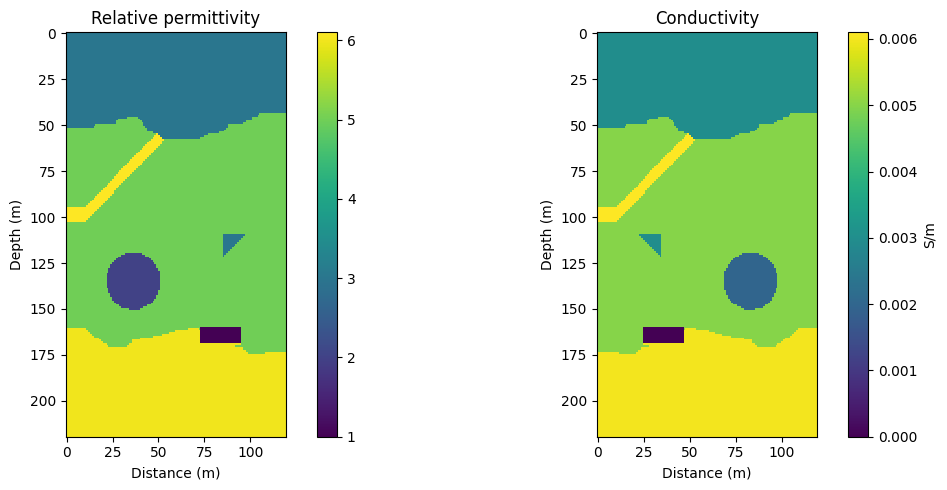

In [1]:
import os
import time
import torch
from src.compute import compute
from src.multiscale import apply_filter
import src.visualization as visualization
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import filters
import matplotlib.pyplot as plt

device = torch.device('cuda')

ep_true=np.load("newmodel.npy")
ep_true = resize(ep_true, (200, 100), order=1, mode='edge', anti_aliasing=True, preserve_range=True)
padded_ep = np.zeros((220, 120))
padded_ep[10:-10, 10:-10] = ep_true
padded_ep[:10, 10:-10] = ep_true[0:1, :].repeat(10, axis=0)
padded_ep[-10:, 10:-10] = ep_true[-1:, :].repeat(10, axis=0)
padded_ep[:, :10] = padded_ep[:, 10:11].repeat(10, axis=1)
padded_ep[:, -10:] = padded_ep[:, -11:-10].repeat(10, axis=1)
ep_t=torch.tensor(padded_ep,device=device).unsqueeze(-1)
ep_truef=np.fliplr(ep_true) 
ep_truef[:100,:]=ep_true[:100,:]
se_true=ep_truef  *0.001
se_true = resize(se_true, (200, 100), order=1, mode='edge', anti_aliasing=True, preserve_range=True)
se_true[(0.0008 <= se_true) & (se_true <= 0.0011)] = 0

padded_s = np.zeros((220, 120))
padded_s[10:-10, 10:-10] = se_true
padded_s[:10, 10:-10] = se_true[0:1, :].repeat(10, axis=0)
padded_s[-10:, 10:-10] = se_true[-1:, :].repeat(10, axis=0)
padded_s[:, :10] = padded_s[:, 10:11].repeat(10, axis=1)
padded_s[:, -10:] = padded_s[:, -11:-10].repeat(10, axis=1)
se_t = torch.tensor(padded_s, device=device).unsqueeze(-1)
mr_t = torch.ones_like(ep_t)
sm_t = torch.zeros_like(ep_t)
epj=ep_true.copy()
epj[epj <= 2.1] = 5
sej=se_true.copy()
sej[sej <= 0.0021] = 0.005
epg=torch.tensor(filters.gaussian(epj,sigma=20),device=device)#[4:-4,4:-4]
sig=torch.tensor(filters.gaussian(sej,sigma=20),device=device)
ep_init=ep_t.clone()
ep_init[10:-10, 10:-10,0]=epg
se_init=se_t.clone()
se_init[10:-10, 10:-10,0]=sig


erdir = 'pred_erdp'
if not os.path.exists(erdir):
    os.makedirs(erdir)

np.save(erdir+'/epg.npy',epg.cpu())
np.save(erdir+'/sig.npy',sig.cpu())
np.save(erdir+'/se_true.npy',se_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(ep_t[:, :, 0].cpu().numpy(),
                     cmap='viridis',
                     interpolation='nearest',
                     aspect='equal')
cbar1 = plt.colorbar(im1, ax=axes[0])
axes[0].set_title('Relative permittivity')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Depth (m)')

# 图2: se_t
im2 = axes[1].imshow(se_t[:, :, 0].cpu().numpy(),
                     cmap='viridis',
                     interpolation='nearest',
                     aspect='equal')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('S/m')
axes[1].set_title('Conductivity')
axes[1].set_xlabel('Distance (m)')
axes[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


dx = torch.tensor(0.05)
nx= torch.tensor(220)
ny= torch.tensor(120)
nz= torch.tensor(1)
dt=1e-10
time_windows = torch.tensor(1e-7)
source = ['hertzian', 'z']

nsrc = 1
nrx = 200
source_step = torch.tensor([0.25, 0, 0])
receiver_step = torch.tensor([0.05, 0, 0])
source_location = torch.tensor([0.5, 0.50, 0])
receiver_location = torch.tensor([0.5, 5.50, 0]) 

step = 40
source_amplitudes = ['ricker', 1, 1e8]
n_epochs = 202

Target_freq=[1e8]

pmlthick=10
observed_data, tt = compute(device, dx, ny, nx, nz, source, source_amplitudes, step, ep_t,
                           se_t, mr_t, nsrc, nrx, time_windows=time_windows,dt=dt,
                           source_location=source_location, source_step=source_step,
                           receiver_location=receiver_location, receiver_step=receiver_step,
                           pmlthick=pmlthick, Fixedreceiver=True
                            )

pdata=observed_data[20,:,:].cpu().numpy()


In [2]:
er=ep_init.clone()
se=se_init.clone()

mr = mr_t.clone()

optimiser_phase1 = torch.optim.Adam([
    {'params': er, 'lr': 0.2},
])

optimiser_phase2 = torch.optim.Adam([
    {'params': er, 'lr': 0.1},
    {'params': se, 'lr': 0.0001}
])
phase1_epochs = 50 
losses = []
Change_freq=1000



loss_fnmse = torch.nn.MSELoss()
loss_fnl1= torch.nn.L1Loss()

start_time = time.time()

for epoch in range(n_epochs):
    if epoch < phase1_epochs:
        current_optimizer = optimiser_phase1
        se.requires_grad = False 
        er.requires_grad = True  
    else:
        current_optimizer = optimiser_phase2
        se.requires_grad = True    
        er.requires_grad = True   
    
    epoch_start = time.time()
    if 'Target_freq' in globals():
        n = epoch // Change_freq
        if n >= len(Target_freq) or len(Target_freq)==1:
            freq = source_amplitudes[2]
            observed_data1=observed_data
        else:
            freq = Target_freq[n]
            observed_data1= apply_filter(observed_data.detach(),1/dt,freq)

    
    current_optimizer.zero_grad()

    result, tt = compute(device, dx, ny, nx, nz, source, source_amplitudes, step, er,
                           se, mr, nsrc, nrx, time_windows=time_windows,dt=dt,
                           source_location=source_location, source_step=source_step,
                           receiver_location=receiver_location, receiver_step=receiver_step,
                           pmlthick=pmlthick, Fixedreceiver=True,freq=freq
                            )
  
    loss = loss_fnl1(result, observed_data) * 100

    loss.backward()
    if er.requires_grad:
        er.grad[:, :pmlthick, :] = 0
        er.grad[:, -pmlthick:, :] = 0
    if se.requires_grad:
        se.grad[:, :pmlthick, :] = 0
        se.grad[:, -pmlthick:, :] = 0
    current_optimizer.step()
    losses.append(loss.item())  # 记录loss值
    epoch_time = time.time() - epoch_start  # 计算当前 epoch 用时
    total_time = time.time() - start_time  # 计算总用时
    ssim_value = visualization.calculatessim(er[pmlthick:-pmlthick, pmlthick:-pmlthick, :], ep_t[pmlthick:-pmlthick, pmlthick:-pmlthick, :])
    print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Freq: {freq/1000000:.0f}MHz, Epoch Time: {epoch_time:.2f}s, Total Time: {total_time:.2f}s")
    save_epoch=10
    if epoch % save_epoch == 0:
        er_ = er[pmlthick:-pmlthick, pmlthick:-pmlthick, :]
        se_ = se[pmlthick:-pmlthick, pmlthick:-pmlthick, :]
        np.save(erdir + "/" + str(int(epoch / save_epoch)) + "sigma.npy", se_.cpu().detach().numpy())
        np.save(erdir + "/" + str(int(epoch /save_epoch)) + "epsilon.npy", er_.cpu().detach().numpy())
    
    with torch.no_grad():
        se.data.clamp_(min=0.000, max=0.006)
        er.data.clamp_(min=1)

    print("-----------")


Total variation regularization took 1.3295 seconds.
Epoch 0, Loss: 14.195280, Freq: 100MHz, Epoch Time: 2.32s, Total Time: 2.32s
-----------
Total variation regularization took 0.1624 seconds.
Epoch 1, Loss: 11.209087, Freq: 100MHz, Epoch Time: 1.15s, Total Time: 3.47s
-----------
Total variation regularization took 0.1593 seconds.
Epoch 2, Loss: 9.236921, Freq: 100MHz, Epoch Time: 1.14s, Total Time: 4.61s
-----------
Total variation regularization took 0.1588 seconds.
Epoch 3, Loss: 8.203887, Freq: 100MHz, Epoch Time: 1.15s, Total Time: 5.75s
-----------
Total variation regularization took 0.1583 seconds.
Epoch 4, Loss: 7.494836, Freq: 100MHz, Epoch Time: 1.15s, Total Time: 6.90s
-----------
Total variation regularization took 0.1577 seconds.
Epoch 5, Loss: 6.623775, Freq: 100MHz, Epoch Time: 1.15s, Total Time: 8.05s
-----------
Total variation regularization took 0.1623 seconds.
Epoch 6, Loss: 5.828004, Freq: 100MHz, Epoch Time: 1.14s, Total Time: 9.19s
-----------
Total variation re

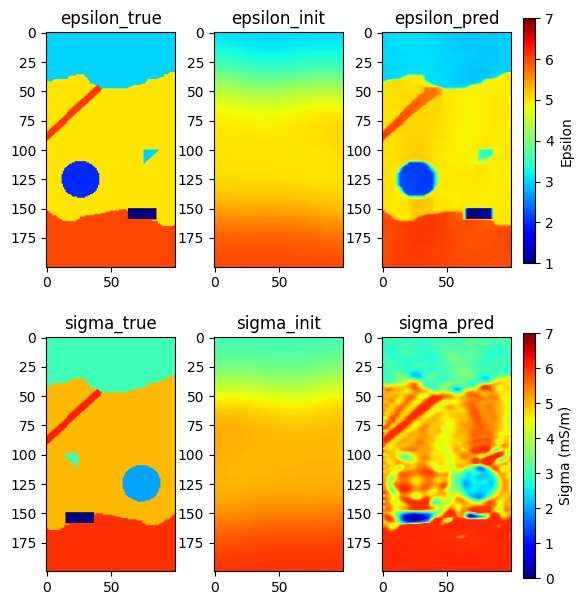

In [3]:

n=15

# 加载数据
ep_true = np.load('newmodel.npy')
ep_true = resize(ep_true, (200, 100), order=1, mode='edge', anti_aliasing=True, preserve_range=True)
epg = np.load('pred_erdp/epg.npy')
epsilon_pred = np.load('pred_erdp/'+str(n)+'epsilon.npy')

se_true = np.load('pred_erdp/se_true.npy')*1000
sig = np.load('pred_erdp/sig.npy')*1000
sigma_pred = np.load('pred_erdp/'+str(n)+'sigma.npy')*1000

fig, axes = plt.subplots(2, 3, figsize=(6, 7))

# 第一行
epsilon_images = [ep_true, epg, epsilon_pred]
for i in range(3):
    im1 = axes[0, i].imshow(epsilon_images[i], cmap='jet', aspect='auto', vmin=1, vmax=7)
    axes[0, i].set_title(['epsilon_true', 'epsilon_init', 'epsilon_pred'][i])

# 第二行
sigma_images = [se_true, sig, sigma_pred]
for i in range(3):
    im2 = axes[1, i].imshow(sigma_images[i], cmap='jet', aspect='auto', vmin=0, vmax=7)
    axes[1, i].set_title(['sigma_true', 'sigma_init', 'sigma_pred'][i])

# 第一行colorbar（右上角）
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.35])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1)
cbar1.set_label('Epsilon')

# 第二行colorbar（右下角）
cbar_ax2 = fig.add_axes([0.92, 0.1, 0.02, 0.35])
cbar2 = fig.colorbar(im2, cax=cbar_ax2)
cbar2.set_label('Sigma (mS/m)')

plt.subplots_adjust(right=0.9, wspace=0.3, hspace=0.3)
plt.show()